In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle as pkl
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal
# import importlib
from importlib import reload
from tqdm.notebook import tqdm
from scipy.signal import savgol_filter

# other options
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['figure.facecolor'] = 'w'
np.set_printoptions(suppress=True)


In [7]:
sobj = hhtools.SummaryLoader("./data", read_cache=False)
sobj_base = hhtools.SummaryLoader("../three_pop_mpi/simulation_data/data")

with open("./data/selected_points.txt", "r") as fp:
    line = fp.readline()
    line = fp.readline()
    
    cid_use = []
    loc_use = []
    # rank_use = []
    while line:
        cid, *vals = map(int, line[:-2].split(","))
        cid_use.append(cid)
        loc_use.append(vals)
        # rank_use.append(vals[2])
        line = fp.readline()

Load cache file


# Spectral property

In [83]:
def _fft(detail, nt):
    idt = detail["ts"] >= 0.5
    vlfp = detail["vlfp"][nt][idt]
    ts = detail["ts"][idt]
    fs = np.round(1/(ts[1] - ts[0]))

    psd, fpsd = hhsignal.get_fft(vlfp, fs, nbin_t=2, frange=(3, 120))
    return psd, fpsd


np.random.seed(100)



psd_set = []
psd_base_set = []
rank_used = []

nsample = 20
for cid in range(1, 9):

    psd_tot = [0, 0, 0]
    for ni in np.random.choice(sobj.num_controls[1], nsample, replace=False):
        detail = sobj.load_detail(cid-1, ni)
    
        for nt in range(3):    
            psd, fpsd = _fft(detail, nt)
            psd_tot[nt] += psd/nsample
    
    psd_set.append(psd_tot)
    
    # base
    psd_base = [0, 0, 0]    
    rank_set = np.array([l[2] for l in loc_use])[np.array(cid_use) == cid]
    
    nr = np.round(np.average(rank_set))
    # print("cid%d: %d"%(cid, nr))
    rank_used.append(nr)
    
    
    for ni in range(5):
        detail_base = sobj_base.load_detail(0, 0, nr, 0, ni)
        for nt in range(3):
            psd_b, fpsd_b = _fft(detail_base, nt)
            psd_base[nt] += psd_b/5
    
    psd_base_set.append(psd_base)


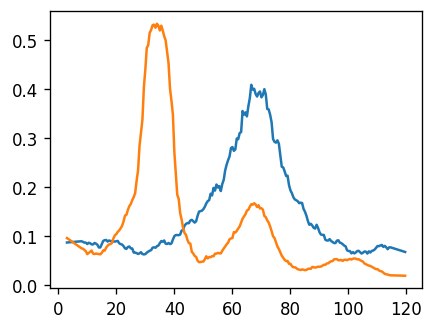

In [116]:
from scipy.signal import savgol_filter

detail_base = sobj_base.load_detail(0, 0, 2, 0, 0)


plt.figure()
for nt in range(1, 3):
    yf, fpsd = _fft(detail_base, nt)
    yf_f = savgol_filter(yf, 21, 1)
    plt.plot(fpsd, yf_f)
    # hhsignal.detect_peak(yf_f)

In [117]:
t = detail_base["ts"]
v = detail_base["vlfp"][2]
psd, fpsd, tpsd = hhsignal.get_stfft(v, t, 2000, frange=(2, 100))

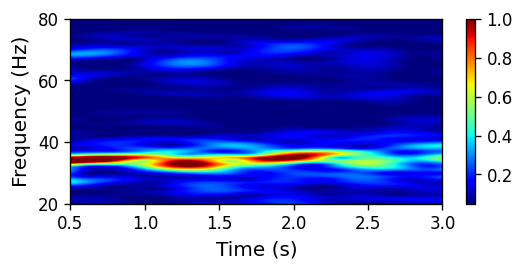

In [149]:
plt.figure(figsize=(5, 2.))
hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet", vmin=0.05, vmax=1, interpolation="bicubic")
# hhtools.imshow_xy(np.log10(psd), x=tpsd, y=fpsd, cmap="jet", vmax=-0.05, vmin=-2, interpolation="bicubic")
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Frequency (Hz)", fontsize=12)
plt.xlim([0.5, 3])
plt.ylim([20, 80])
plt.colorbar()
plt.show()

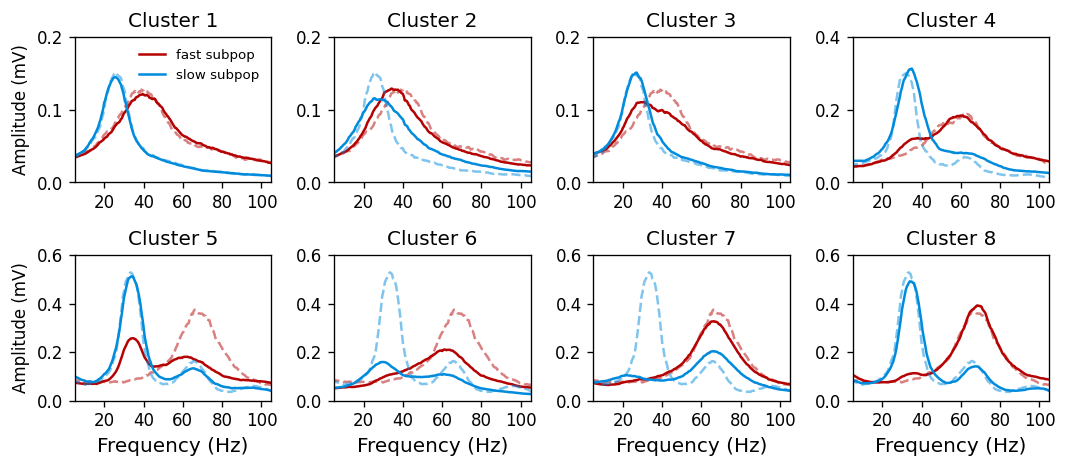

In [103]:
cset = ["k", "#b50202", "#008bdd"]
name = ["tot", "fast subpop", "slow subpop"]

yl_set = [[0, 0.2], [0, 0.4], [0., 0.6]]

plt.figure(dpi=120, figsize=(9, 4))
for nc in range(8):
    plt.subplot(2,4,nc+1)
    
    for nt in range(1, 3):
        yhat = savgol_filter(psd_set[nc][nt], 21, 1)
        plt.plot(fpsd, yhat, c=cset[nt], label=name[nt])
        
        yhat = savgol_filter(psd_base_set[nc][nt], 21, 1)
        plt.plot(fpsd_b, yhat, c=cset[nt], alpha=0.5, linestyle='--')
        
    # plt.xlim([5, 105])
    plt.title("Cluster %d"%(nc+1))
    plt.xticks(np.arange(0, 120, 20))
    plt.xlim([5, 105])
    yl = yl_set[int(rank_used[nc])]
    plt.ylim(yl)
    
    plt.yticks(np.arange(yl[0], yl[1]+1e-3, 0.1 if yl[1] < 0.3 else 0.2))
        
    if nc % 4 == 0:
        plt.ylabel("Amplitude (mV)", fontsize=10)
    
    if nc > 3:
        plt.xlabel("Frequency (Hz)", fontsize=12)
        
    if nc == 0:
        plt.legend(loc="upper right", edgecolor="none", fontsize=8)
    
#     plt.twinx()
#     for nt in range(1, 3):
#         yhat = savgol_filter(psd_base_set[nc][nt], 21, 1)
#         plt.plot(fpsd_b, yhat, c=cset[nt], alpha=0.5, linestyle='--')
    
    
#     plt.ylim([0, 0.6])
    
    # plt.ylim([0, 0.8])
    
plt.tight_layout()
plt.show()

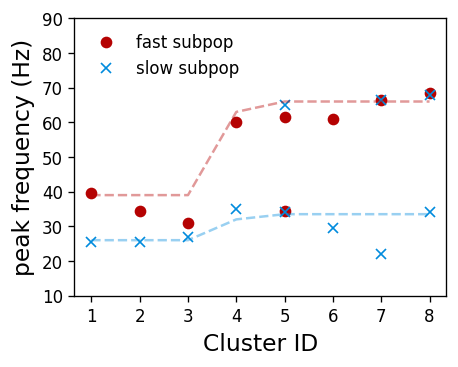

In [115]:
plt.figure()

cset = ["k", "#b50202", "#008bdd"]
markers = ["", "o", "x"]

fpeaks_b = [[], [], []]

for nc in range(8):
    for nt in range(1, 3):
        yhat = savgol_filter(psd_set[nc][nt], 21, 1)
        npeaks = hhsignal.detect_peak(yhat, prominence=0.015, mode=0)
        
        for n in npeaks:
            lb = name[nt] if nc == 1 else ""
            plt.plot(nc+1, fpsd[n], markers[nt], color=cset[nt], label=lb)
            
        yhat_b = savgol_filter(psd_base_set[nc][nt], 21, 1)
        npeaks = hhsignal.detect_peak(yhat_b, prominence=0.04, mode=0)
        
        fpeaks_b[nt].append(fpsd[npeaks[0]])

plt.plot(np.arange(8)+1, fpeaks_b[1], '--', c=cset[1], alpha=0.4)
plt.plot(np.arange(8)+1, fpeaks_b[2], '--', c=cset[2], alpha=0.4)

plt.xticks(np.arange(1, 9))
plt.ylim([10, 90])

plt.xlabel("Cluster ID", fontsize=14)
plt.ylabel("peak frequency (Hz)", fontsize=14)
plt.legend(loc="upper left", edgecolor="none", fontsize=10)

plt.show()

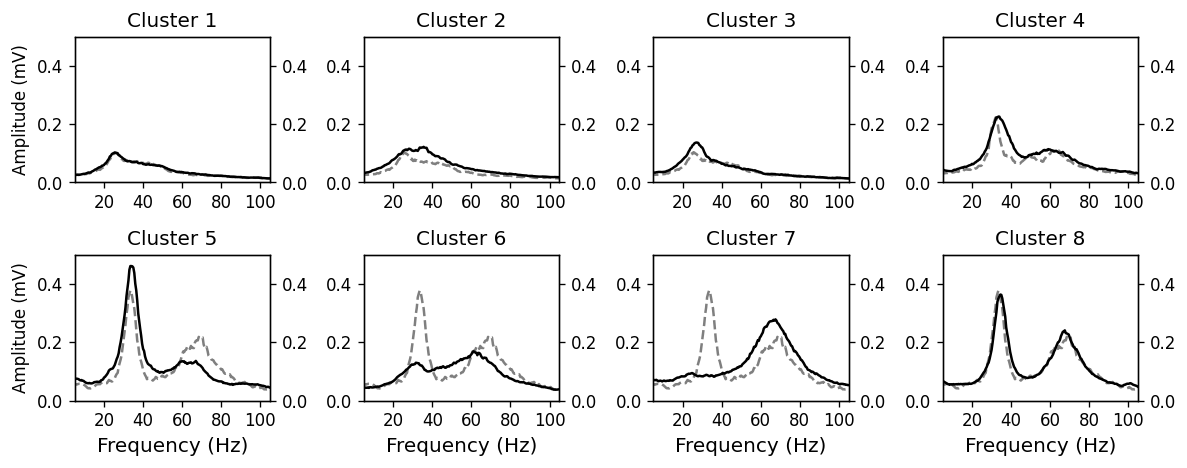

In [9]:
from scipy.signal import savgol_filter

cset = ["k", "#b50202", "#008bdd"]
name = ["tot", "fast", "slow"]

plt.figure(dpi=120, figsize=(10, 4))
for nc in range(8):
    plt.subplot(2,4,nc+1)
    
    yhat = savgol_filter(psd_set[nc][0], 9, 1)
    plt.plot(fpsd, yhat, c=cset[0], label=name[0])
        
    plt.title("Cluster %d"%(nc+1))
    plt.xticks(np.arange(0, 120, 20))
    plt.ylim([0, 0.5])
        
    if nc % 4 == 0:
        plt.ylabel("Amplitude (mV)", fontsize=10)
    
    if nc > 3:
        plt.xlabel("Frequency (Hz)", fontsize=12)
    
    plt.twinx()
    yhat = savgol_filter(psd_base_set[nc][0], 9, 1)
    plt.plot(fpsd_b, yhat, c=cset[0], alpha=0.5, linestyle='--')
    
    plt.xlim([5, 105])
    plt.ylim([0, 0.5])
    
plt.tight_layout()
plt.show()

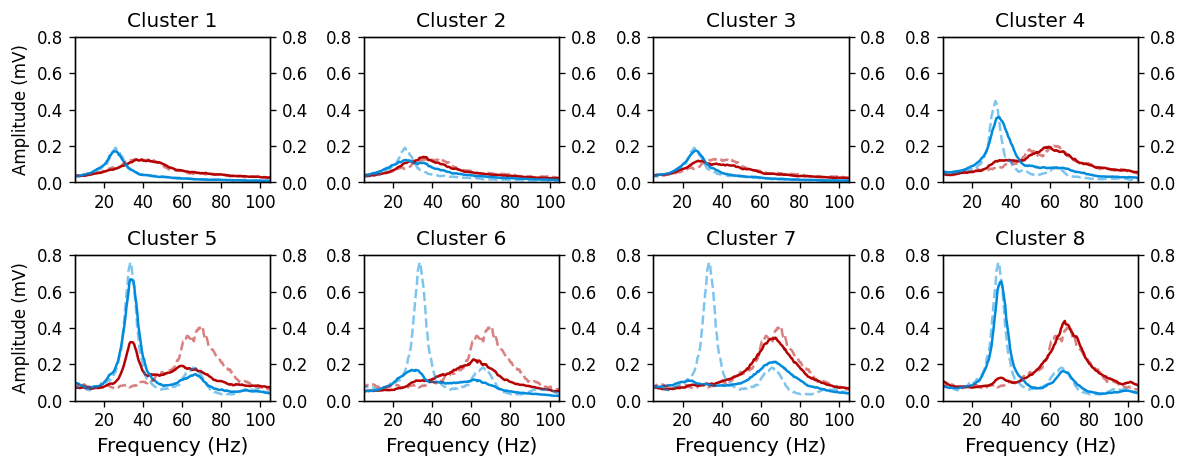